## High Frequency Trading

### Expirimental Results

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from src import MarketMaker, MarketSimulation

In [2]:
# Time horizon
T = 60              # 60 minutes
N = T * 60          # one step per second

# Inventory constraints
q_min = -50         # largest allowed short position
q_max = 50          # largest allowed long position

X_0 = 100           # initial capital

# Market parameters
S_0 = 100           # initial price
mu = 0              # drift parameter
sigma = 0.01        # volatility parameter
ds = 0.01           # tick size
lambda_bid = 50     # Number of market order arrivals per minute on the bid
lambda_ask = 50     # Number of market order arrivals per minute on the ask
kappa_bid = 100     # Decay parameter for "fill rate" on the bid
kappa_ask = 100     # Decay parameter for "fill rate" on the ask
rebate = 0.0025     # rebate rate for providing liquidity
cost = 0.005        # cost for taking liquidity

# Inventory penalty parameters
phi = 0.01          # running inventory penalty parameter
alpha = 0           # terminal inventory penalty parameter

In [3]:
agent = MarketMaker(T, N, q_min, q_max, lambda_bid, lambda_ask, kappa_bid, kappa_ask, rebate, cost, phi, alpha)
agent.optimize()

Solving HJB-QVI: 100%|██████████| 3600/3600 [09:12<00:00,  6.52it/s]


### Results

#### Value Function

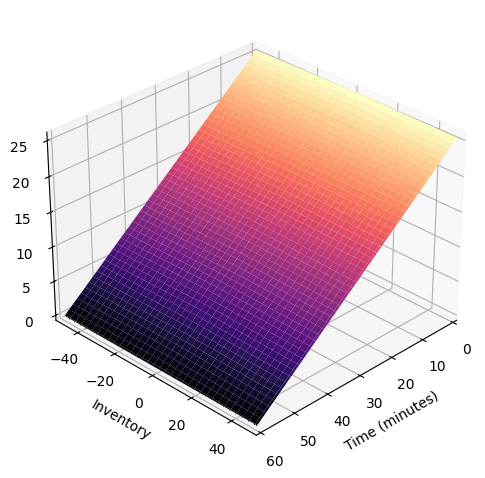

In [21]:
value_function = agent.V

# Plot the value function
X = value_function.t_grid
Y = value_function.q_grid
X, Y = np.meshgrid(X, Y)


pp3d = plt.axes(projection="3d")
plt.tight_layout()
# rotate the axes and update
pp3d.view_init(30, 45)
pp3d.set_xlabel("Time (minutes)")
pp3d.set_ylabel("Inventory")
pp3d.plot_surface(X, Y, value_function.V.T, cmap='magma')
pp3d.set_xlim([0, T])
pp3d.set_ylim([q_min, q_max])
pp3d.set_zlim([value_function.V.min(), value_function.V.max()])
pp3d.set_zlim([value_function.V.min(), value_function.V.max()])

plt.show()

### Simulations

In [15]:
environment = MarketSimulation(T, N, q_min, q_max, X_0, S_0, mu, sigma, ds, lambda_bid, lambda_ask, kappa_bid, kappa_ask, rebate, cost)

M = 1000
W = np.zeros((M, N + 1))
S = np.zeros((M, N + 1))

W[:, 0] = X_0
S[:, 0] = S_0

for i in tqdm(range(M), desc="Running simulations"):
    done = False
    state = environment.reset()

    while not done:
        action = agent.run(state)
        state, wealth, done, j = environment.step(action)
        W[i][j] = wealth
        S[i][j] = state.mid_price

Running simulations:   0%|          | 0/1000 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 1000/1000 [02:48<00:00,  5.94it/s]


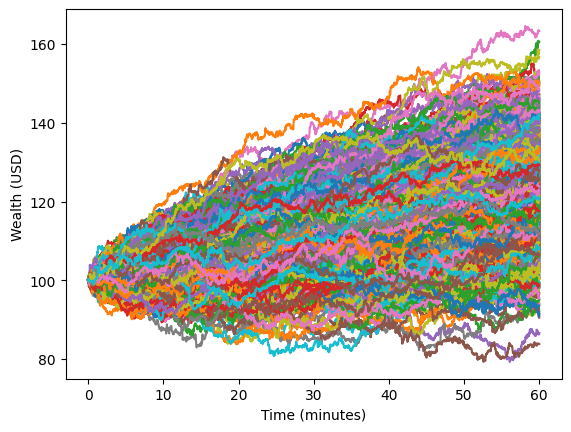

In [23]:
plt.plot(environment.t_grid, W.T)

plt.xlabel('Time (minutes)')
plt.ylabel('Wealth (USD)')
plt.show()

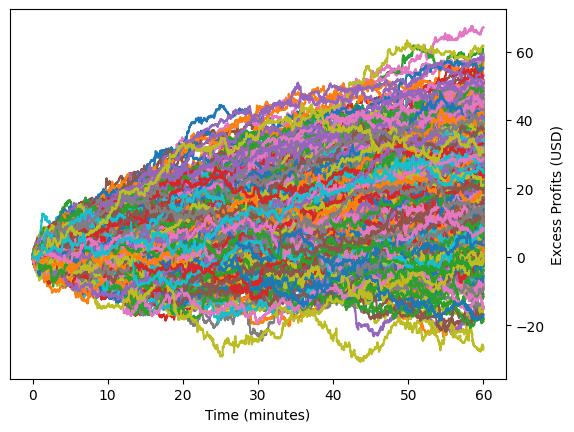

In [39]:
U = W - S
plt.plot(environment.t_grid, U.T)

plt.xlabel('Time (minutes)')
plt.ylabel('Excess Profits (USD)')
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.show()

Mean:  21.860203773988868
Std:  12.013101188361027


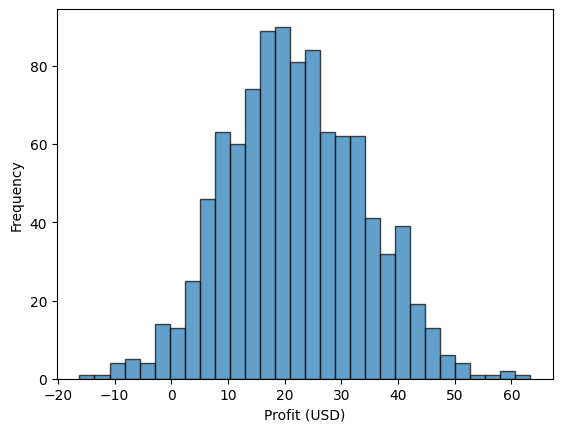

In [53]:
# plot a histogram of the final wealth
plt.hist(W[:, -1] - W[:, 0], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Profit (USD)')
plt.ylabel('Frequency')


print("Mean: ", np.mean((W[:, -1] - W[:, 0])))
print("Std: ", np.std((W[:, -1] - W[:, 0])))

Mean:  21.83907377398887
Std:  13.851199081514332


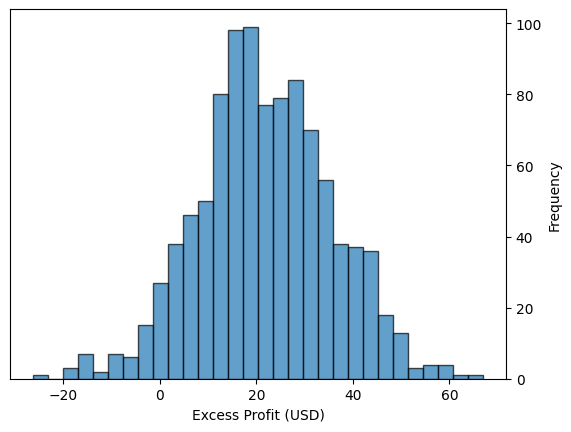

In [52]:
# plot a histogram of the final wealth
plt.hist((W[:, -1] - W[:, 0]) - (S[:, -1] - S[:, 0]), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Excess Profit (USD)')
plt.ylabel('Frequency')
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

print("Mean: ", np.mean((W[:, -1] - W[:, 0]) - (S[:, -1] - S[:, 0])))
print("Std: ", np.std((W[:, -1] - W[:, 0]) - (S[:, -1] - S[:, 0])))